In [1]:
"""
This is a module for training and testing the model:
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras import Input
from keras.utils import to_categorical
from scipy.stats import ttest_ind
from sklearn import svm, linear_model, metrics
sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# for reproducibility
np.random.seed(20201005)

# upload the files at the google colab
from google.colab import files
uploaded = files.upload() # SENT_GROUP_INFO
uploaded2 = files.upload() # SENT_RATING
uploaded3 = files.upload() # SENTECES_ORDER, It's in the ANPP folder

Saving SENT_GROUP_INFO.xlsx to SENT_GROUP_INFO.xlsx


Saving SENT_RATING_DATA.xlsx to SENT_RATING_DATA.xlsx


Saving SENTENCES_ORDER.xlsx to SENTENCES_ORDER.xlsx


In [17]:
# Bring the candidate factors in the dataset
sg_factors = "B:E,J,AE:AI,BE,BF,CW:DJ,DM,DN,DP,EC,EE,EF,FN"

# Load the factors datasets
s_group = pd.read_excel('SENT_GROUP_INFO.xlsx', usecols = sg_factors)
s_rating = pd.read_excel('SENT_RATING_DATA.xlsx')

# SENT_GROUP_INFO
# Check the NaN in both the s_group and the s_rating

# print(s_group.isnull().sum())
# print(s_rating.isnull().sum())
# plt.plot(s_rating['CASE'], s_rating['PAGE_TIME'])

# Save the CASE exclusion list
b_DEG = s_group.loc[s_group['DEG_TIME']>100]['CASE']
# print(b_DEG)
b_ATT = s_group.loc[s_group['ATTENTION_CHECKS_COUNT_CORRECT_ANSWERS']<2]['CASE']
# print(b_ATT)
b_PAG = s_rating.loc[s_rating['PAGE_TIME']>999]['CASE']
# print(b_PAG)

# Concatenate the bad data list
b_list = pd.concat([b_DEG, b_ATT, b_PAG], axis = 0)
# print(b_list)

# Delete the duplicates and make a list
b_list = b_list.drop_duplicates()
# print(b_list)

# Convert list
b_case = list(b_list.values)
# print(b_case)

# Excluded the bad case from the dataset
e_group = []
e_rating = []
a_group = s_group.copy()
a_rating = s_rating.copy()

for i in b_case:
    a_rating = a_rating.drop(a_rating[a_rating['CASE'] == i].index)
    a_group = a_group.drop(a_group[a_group['CASE'] == i].index)
    if i == 46:
        e_group = a_group
        e_rating = a_rating

# Create the new column of 'IMMERSION'
e_group['IMMERSION'] = 0

# Sum the readers response
for i in range (14):
    e_group['IMMERSION'] += e_group.iloc[:,i+12]

# Using the mean of the reader's response
e_group['IMMERSION']=e_group['IMMERSION']/14
# print(e_group.head(10))
# sns.distplot(e_group["IMMERSION"])

# Load the label related dataset
ld = e_group.loc[:, ['CASE','TEXT','CONDITION','QESTN_LANGUAGE',
                     'BFI_OPENNESS','IMMERSION']]
# print(ld.shape, 'Total')

# lh = ld.loc[ld['TEXT']=='HARRY']
# Load the harry - coherent related dataset
# print("Coherent, Sent Group Dataset for Label")
lh = ld.loc[ld['TEXT']=='HARRY'].loc[ld['CONDITION']=='COHERENT']
# print(lh.shape, 'Coherent Text, Harry')
lh_eng = lh.loc[lh['QESTN_LANGUAGE']=='ENG']
lh_ger = lh.loc[lh['QESTN_LANGUAGE']=='GER']

# Load the pippi - coherent related group dataset
# lp = ld.loc[ld['TEXT']=='PIPPI']
lp = ld.loc[ld['TEXT']=='PIPPI'].loc[ld['CONDITION']=='COHERENT']
# print(lp.shape, 'Coherent Text, Pipi')
lp_eng = lp.loc[lp['QESTN_LANGUAGE']=='ENG']
lp_ger = lp.loc[lp['QESTN_LANGUAGE']=='GER']


# print(lh_eng.shape, 'Harry, ENG')
# print(lh_ger.shape, 'Harry, GER')
# print(lp_eng.shape, 'Pippi, ENG')
# print(lp_ger.shape, 'Pippy, GER')

################################################################################
# Load the rating related group dataset
rd = e_rating.loc[:, ['CASE','TEXT','CONDITION','LANGUAGE',"SENTENCE_NUMBER",
                      'AROUSAL_RATING','VALENCE_RATING']]
# print(rd.shape, 'Total')

# rh = rd.loc[rd['TEXT']=='HARRY']
# Load the harry related rating dataset
# print('Sent Rating Dataset for Input')
rh = rd.loc[rd['TEXT']=='HARRY'].loc[rd['CONDITION']=='COHERENT']
# print(rh.shape, 'Coherent Text, Harry')
rh_eng = rh.loc[rh['LANGUAGE']=='ENG']
rh_ger = rh.loc[rh['LANGUAGE']=='GER']

# Load the pippi related rating dataset
# rp = rd.loc[rd['TEXT']=='PIPPI']
rp = rd.loc[rd['TEXT']=='PIPPI'].loc[rd['CONDITION']=='COHERENT']
# print(rp.shape, 'Coherent Text, Pippi')

# Delete the NAN dataset
rp_eng = rp.loc[rp['LANGUAGE']=='ENG'].dropna(axis=0)
rp_ger = rp.loc[rp['LANGUAGE']=='GER'].dropna(axis=0)

# Check the NaN dataset
# print(rh_eng.shape, 'ENG')
# print(rh_eng.isnull().sum(), 'NaN')
# print(rh_ger.shape, 'GER')
# print(rh_ger.isnull().sum(), 'NaN')

# Check the NaN dataset
# print(rp_eng.shape, 'ENG')
# print(rp_eng.isnull().sum(), 'NaN')
# print(rp_ger.shape, 'GER')
# print(rp_ger.isnull().sum(), 'NaN')

# Load the coherent case number
ch_eng = list(lh_eng.loc[:,['CASE']]['CASE'])
ch_ger = list(lh_ger.loc[:,['CASE']]['CASE'])
# print(ch_eng)
# print(ch_ger)

# Training set, Test set Case Number
tr_case = ch_eng[:13] + ch_ger[:7]
te_case = ch_eng[13:] + ch_ger[7:]
# print(tr_case)
# print(te_case)

# Concatenate ENG and GER Harry coherent dataset
lh_set = pd.concat([lh_eng, lh_ger], axis = 0)
# print(lh_set)

# Prepare the label dataset

# Extract only Immersion data
train_label = []
test_label = []

case = [tr_case, te_case]
for i in case:
    for j in i:
        if i == tr_case:
            train_label.append(list(lh_set[lh_set['CASE']==j]['IMMERSION']))
        else:
            test_label.append(list(lh_set[lh_set['CASE']==j]['IMMERSION']))

# print(train_label)
# print(test_label)

################################################################################
# Prepare the data dataset

# Extract only BFI_Openness
train_bfi = []
test_bfi = []

for i in case:
    for j in i:
        if i == tr_case:
            train_bfi.append(list(lh_set[lh_set['CASE']==j]['BFI_OPENNESS']))
        else:
            test_bfi.append(list(lh_set[lh_set['CASE']==j]['BFI_OPENNESS']))

# print(train_bfi)
# print(test_bfi)

# Load the coherent harry sentence order
sentences_order = pd.read_excel('SENTENCES_ORDER.xlsx')
order = sentences_order.loc[:,['SURVEY_ORDER']]['SURVEY_ORDER']
oh_lang = list(order)
# print(oh_lang)

# Concatenate ENG and GER Harry coherent dataset
rh_set = pd.concat([rh_eng, rh_ger], axis = 0)
# print(rh_set)

# Extract both Arousal and Valence

train_arousal = []
train_valence = []
test_arousal = []
test_valence = []

for i in case:
    for j in i:
        if i == tr_case:
            set = rh_set[rh_set['CASE']==j]
            set['SURVEY_ORDER'] = oh_lang
            new = set.sort_values(by='SURVEY_ORDER')
            train_arousal.append(list(new.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            train_valence.append(list(new.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))
        else:
            set = rh_set[rh_set['CASE']==j]
            set['SURVEY_ORDER'] = oh_lang
            new = set.sort_values(by='SURVEY_ORDER')
            test_arousal.append(list(new.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            test_valence.append(list(new.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
# Dataset as a list
print('Dataset')
print('Training set')
print(train_bfi)
print(train_arousal)
print(train_valence)
print(train_label)
print('Test set')
print(test_bfi)
print(test_arousal)
print(test_valence)
print(test_label)

Dataset
Training set
[[4.0], [3.0], [3.0], [3.0], [4.5], [3.5], [4.0], [1.5], [5.0], [5.0], [5.0], [4.5], [3.0], [4.0], [4.5], [2.5], [5.0], [4.5], [5.0], [4.5]]
[[2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 4.0, 3.0, 4.0, 2.0, 2.0, 4.0, 4.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 4.0, 2.0, 4.0, 2.0, 4.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 2.0, 4.0, 2.0, 2.0, 3.0, 2.0, 2.0, 3.0, 4.0, 4.0, 4.0, 2.0, 4.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 4.0, 2.0, 4.0, 4.0, 4.0, 2.0, 2.0, 3.0, 2.0, 3.0, 3.0], [3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 2.0, 3.0, 4.0, 3.0, 2.0, 2.0, 4.0, 2.0, 3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0,

In [19]:
# Dataset as np.array
tr_bfi = np.array(train_bfi)
tr_arousal = np.array(train_arousal)
tr_valence = np.array(train_valence)
tr_label = np.array(train_label)
te_bfi = np.array(test_bfi)
te_arousal = np.array(test_arousal)
te_valence = np.array(test_valence)
te_label = np.array(test_label)

print('Dataset')
print('Training set')
print(tr_bfi)
print(tr_arousal)
print(tr_valence)
# print(tr_label)
print('Test set')
print(te_bfi)
print(te_arousal)
print(te_valence)
# print(te_label)

Dataset
Training set
[[4. ]
 [3. ]
 [3. ]
 [3. ]
 [4.5]
 [3.5]
 [4. ]
 [1.5]
 [5. ]
 [5. ]
 [5. ]
 [4.5]
 [3. ]
 [4. ]
 [4.5]
 [2.5]
 [5. ]
 [4.5]
 [5. ]
 [4.5]]
[[2. 2. 3. ... 2. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [4. 4. 5. ... 3. 4. 2.]
 ...
 [5. 4. 4. ... 3. 4. 4.]
 [4. 4. 4. ... 3. 3. 4.]
 [4. 4. 2. ... 2. 4. 2.]]
[[2. 5. 5. ... 5. 4. 4.]
 [4. 4. 4. ... 5. 4. 4.]
 [2. 2. 6. ... 4. 6. 6.]
 ...
 [5. 5. 4. ... 4. 6. 6.]
 [6. 5. 5. ... 6. 6. 5.]
 [6. 6. 6. ... 5. 5. 5.]]
Test set
[[3. ]
 [3. ]
 [3.5]
 [1.5]
 [3.5]
 [3. ]]
[[3. 4. 5. 5. 3. 1. 5. 4. 1. 2. 2. 4. 3. 2. 4. 1. 2. 3. 3. 4. 4. 5. 4. 2.
  2. 1. 3. 2. 1. 4. 4. 1. 3. 2. 2. 4. 3. 3. 1. 2. 4. 4. 4. 4. 4. 3. 4. 4.
  4. 1. 4. 3. 2. 4. 3. 4. 3. 2. 4. 2. 4. 3. 3. 2. 1. 4. 1. 3. 2. 4. 3. 2.
  4. 4. 2. 1. 4. 2. 3. 3. 3. 4. 5. 5. 5. 1. 4. 5. 2. 3. 2. 1. 1. 1. 3. 4.
  1. 4. 3. 2. 4. 4. 1. 1. 5. 4. 5. 4. 4. 3. 3. 2. 3. 3. 3. 1. 1. 5. 2. 1.
  1. 2. 3. 2. 2.]
 [4. 4. 5. 2. 4. 4. 5. 3. 3. 3. 3. 3. 3. 3. 4. 2. 2. 2. 3. 2. 2. 4. 3. 3.
  3. 1. 3. 4

In [20]:
# Concatenate to design flatten (1,) dataset
print(tr_bfi.shape)
print(tr_arousal.shape)
print(tr_valence.shape)
print(te_bfi.shape)
print(te_arousal.shape)
print(te_valence.shape)

tr_dataset = np.concatenate((tr_bfi, tr_arousal, tr_valence), axis = 1)
te_dataset = np.concatenate((te_bfi, te_arousal, te_valence), axis = 1)

print(tr_dataset.shape)
print(te_dataset.shape)

(20, 1)
(20, 125)
(20, 125)
(6, 1)
(6, 125)
(6, 125)
(20, 251)
(6, 251)


In [23]:
# dataset (20,251,1)

tr_data2 = np.expand_dims(tr_dataset,axis=2)
te_data2 = np.expand_dims(te_dataset,axis=2)

print(tr_data2.shape)
print(te_data2.shape)
print(tr_label.shape)
print(te_label.shape)

(20, 251, 1)
(6, 251, 1)
(20, 1)
(6, 1)


In [27]:
# dataset (20, 125, 3)
tr_bfi_data = tr_bfi.copy()
te_bfi_data = te_bfi.copy()
for i in range(124):
    tr_bfi_data = np.concatenate((tr_bfi_data, tr_bfi), axis = 1)
    te_bfi_data = np.concatenate((te_bfi_data, te_bfi), axis = 1)

# print(tr_bfi_data.shape)
# print(tr_arousal.shape)
# print(tr_valence.shape)
# print(te_bfi_data.shape)
# print(te_arousal.shape)
# print(te_valence.shape)
# print(tr_label.shape)
# print(te_label.shape)

tr_bfi_data3 = np.expand_dims(tr_bfi_data, axis=2)
te_bfi_data3 = np.expand_dims(te_bfi_data, axis=2)
tr_arousal_data3 = np.expand_dims(tr_arousal, axis=2)
te_arousal_data3 = np.expand_dims(te_arousal, axis=2)
tr_valence_data3 = np.expand_dims(tr_valence, axis=2)
te_valence_data3 = np.expand_dims(te_valence, axis=2)

print('training set')
print(tr_bfi_data3.shape)
print(tr_arousal_data3.shape)
print(tr_valence_data3.shape)
print('test set')
print(te_bfi_data3.shape)
print(te_arousal_data3.shape)
print(te_valence_data3.shape)

print('dataset (125,3)')
tr_data3 = np.stack([tr_bfi_data, tr_arousal, tr_valence], axis=2)
te_data3 = np.stack([te_bfi_data, te_arousal, te_valence], axis=2)
print(tr_data3.shape)
print(te_data3.shape)
print(tr_label.shape)
print(te_label.shape)

training set
(20, 125, 1)
(20, 125, 1)
(20, 125, 1)
test set
(6, 125, 1)
(6, 125, 1)
(6, 125, 1)
dataset (125,3)
(20, 125, 3)
(6, 125, 3)
(20, 1)
(6, 1)


processing fold #: 1
processing fold #: 2
processing fold #: 3
processing fold #: 4


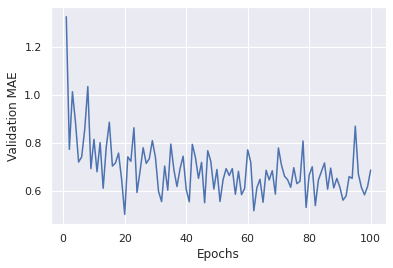

1/1 [==============================] - 0s 1ms/step - loss: 0.9190 - mae: 0.7202
exprected_value 4.782105445861816 	 real_value [3.23214286]
exprected_value 4.192052841186523 	 real_value [3.1547619]
exprected_value 3.8251397609710693 	 real_value [5.23809524]
exprected_value 4.093287944793701 	 real_value [4.14285714]
exprected_value 4.458124160766602 	 real_value [4.32142857]
exprected_value 3.997817039489746 	 real_value [3.86309524]
1/1 [==============================] - 0s 1ms/step - loss: 0.9190 - mae: 0.7202
[0.9190151691436768, 0.7201992869377136]


In [38]:
################################################################################
# : Neural network (Shallow neural network), No dimension, 
################################################################################
"""
Pending, Shallow network with inputshape flatten (1,)
K = 4 cross-validation
"""

train_data = tr_dataset.copy()
test_data = te_dataset.copy()
train_label = tr_label.copy()
test_label = te_label.copy()

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# K-fold cross-validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_mae_scores = []
for i in range(k):
    print('processing fold #:', i+1)
    val_data = train_data[i*num_val_samples: (i + 1)*num_val_samples]
    val_targets = train_label[i*num_val_samples: (i+1)*num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis = 0)
    partial_train_targets = np.concatenate(
        [train_label[:i * num_val_samples],
         train_label[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs = num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_scores.append(mae_history)
    # val_mse, val_mae = model.evaluate(val_data, val_targets, vebose=0)
    # all_scores.append(val_mae)

average_mae_history = [np.mean([x[i] for x in all_mae_scores]) for i in range(num_epochs)]

# Validation MAE Visualization
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Final model
model = build_model()
model.fit(train_data, train_label,
          epochs=100, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_label)

result = model.predict(test_data, verbose=0)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", test_label[i])
print(model.evaluate(test_data, test_label))

In [36]:
################################################################################
# : Neural network (Shallow neural network), Continuous
################################################################################
"""
Pending, Shallow network with inputshape (251,1)
No-specific validation, no cross-validation
"""
train_data = tr_data2.copy()
test_data = te_data2.copy()
train_label = tr_label.copy()
test_label = te_label.copy()

model = Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape =(251,1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(50,activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(train_data, train_label, epochs =100, verbose=0)
result = model.predict(test_data)
print(result)
print(test_label)
print(model.evaluate(test_data, test_label))

# final training and prediction
model.fit(train_data, train_label, epochs =100, verbose=0)
result = model.predict(test_data)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", test_label[i])
print(model.evaluate(test_data, test_label))
# print(result)
# print(test_label)
print(model.evaluate(test_data, test_label))

[[4.056791 ]
 [3.755169 ]
 [3.7399225]
 [3.988656 ]
 [4.833115 ]
 [4.348015 ]]
[[3.23214286]
 [3.1547619 ]
 [5.23809524]
 [4.14285714]
 [4.32142857]
 [3.86309524]]
1/1 [==============================] - 0s 1ms/step - loss: 0.6343
0.6343004703521729


processing fold #: 0


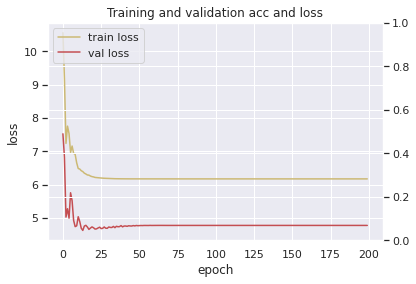

processing fold #: 1


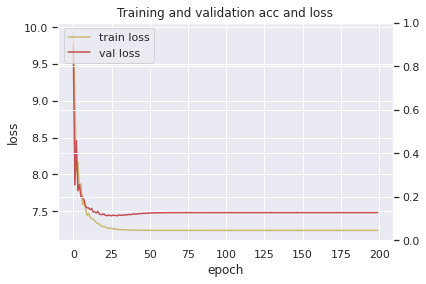

processing fold #: 2


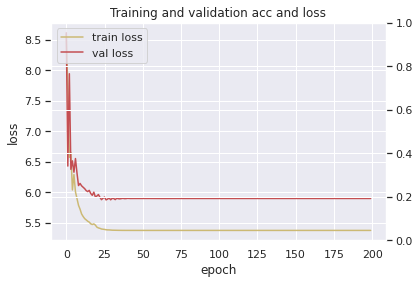

processing fold #: 3


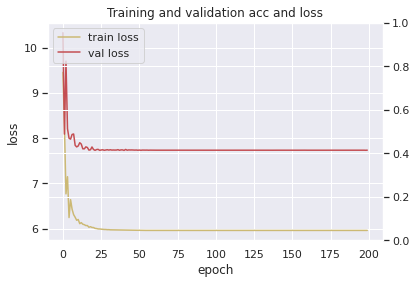

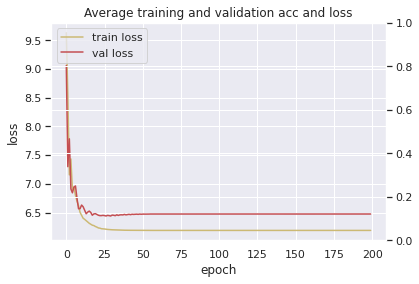

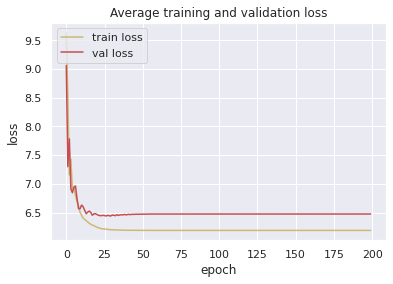

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 250, 64)           192       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 125, 64)           0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 8000)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                400050    
Total params: 400,242
Trainable params: 400,242
Non-trainable params: 0
_________________________________________________________________
exprected_value 2.3052387952804567 	 real_value [3.23214286]
exprected_value 2.3818727588653563 	 real_value [3.1547619]
exprected_value 2.1309539604187013 	 real_value [5.23809524]
exprected_value 2.313309741020203 	 real_value [4.14285714]
exp

In [32]:
################################################################################
# : Neural network (1D convolutional neural network), 
################################################################################
"""
Pending, CNN 1D with inputshape (251,1)
"""

train_data = tr_data2.copy()
test_data = te_data2.copy()
train_label = tr_label.copy()
test_label = te_label.copy()

def build_model():
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu',
                           input_shape=(251,1)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.compile(optimizer='adam',loss='mse')
    return model

# K-fold cross-validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 200
all_acc_histories = []
all_loss_histories = []
all_val_loss_histories = []
all_val_acc_histories = []

for i in range(k):
    print('processing fold #:', i)
    val_data = train_data[i*num_val_samples: (i + 1)*num_val_samples]
    val_label = train_label[i*num_val_samples: (i+1)*num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis = 0)
    partial_train_label = np.concatenate(
        [train_label[:i * num_val_samples],
         train_label[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_label,
                        validation_data=(val_data, val_label),
                        epochs = num_epochs, batch_size=5, verbose=0)

    # Shows the acc and loss plot
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    plt.title('Training and validation acc and loss')
    loss_ax.plot(history.history['loss'],'y',label = 'train loss')
    loss_ax.plot(history.history['val_loss'],'r',label = 'val loss')

    #acc_ax.plot(history.history['acc'],'b',label = 'train acc')
    #acc_ax.plot(history.history['val_acc'],'g',label = 'val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    #acc_ax.set_ylabel('accuracy')

    loss_ax.legend(loc = 'upper left')
    #acc_ax.legend(loc = 'lower left')
    plt.show()

    # Save the histories: acc, loss, val_acc, and val_loss
    #all_acc_histories.append(history.history['acc'])
    all_loss_histories.append(history.history['loss'])
    #all_val_acc_histories.append(history.history['val_acc'])
    all_val_loss_histories.append(history.history['val_loss'])

# Compute the average histories
#average_acc_history = [
#            np.mean([x[i] for x in all_acc_histories])
#            for i in range(num_epochs)]
average_loss_history = [
            np.mean([x[i] for x in all_loss_histories]) 
            for i in range(num_epochs)]
#average_val_acc_history = [
#            np.mean([x[i] for x in all_val_acc_histories]) 
#            for i in range(num_epochs)]
average_val_loss_history = [
            np.mean([x[i] for x in all_val_loss_histories]) 
            for i in range(num_epochs)]

# Shows the average acc and loss plot
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
plt.title('Average training and validation acc and loss')
loss_ax.plot(average_loss_history,'y',label = 'train loss')
loss_ax.plot(average_val_loss_history,'r',label = 'val loss')
#acc_ax.plot(average_acc_history,'b',label = 'train acc')
#acc_ax.plot(average_val_acc_history,'g',label = 'val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc = 'upper left')
#acc_ax.legend(loc = 'lower left')
plt.show()

# Shows the average loss plot
fig, loss_ax = plt.subplots()
plt.title('Average training and validation loss')
loss_ax.plot(average_loss_history,'y',label = 'train loss')
loss_ax.plot(average_val_loss_history,'r',label = 'val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc = 'upper left')
plt.show()

# Shows the average acc plot
# fig, acc_ax = plt.subplots()
# plt.title('Average training and validation acc')
#acc_ax.plot(average_acc_history,'b',label = 'train acc')
#acc_ax.plot(average_val_acc_history,'g',label = 'val acc')
# loss_ax.set_xlabel('epoch')
#acc_ax.set_ylabel('accuracy')
#acc_ax.legend(loc = 'lower right')
#plt.show()
model.summary()

result = model.predict(test_data, verbose=0)
for i, e in enumerate(result):
    print("exprected_value",sum(e,0.0)/len(e), '\t', "real_value", test_label[i])
print(model.evaluate(test_data, test_label))

# final training and prediction
model.fit(train_data, train_label, epochs =100, verbose=0)
result = model.predict(test_data)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", test_label[i])
print(model.evaluate(test_data, test_label))
# print(result)
# print(test_label)
print(model.evaluate(test_data, test_label))

processing fold #: 0


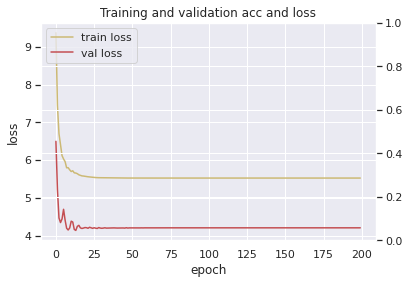

processing fold #: 1


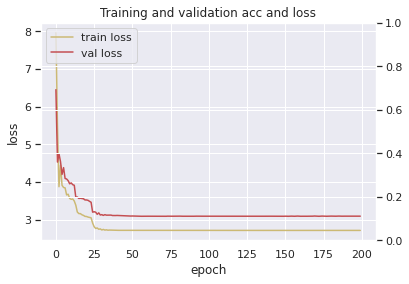

processing fold #: 2


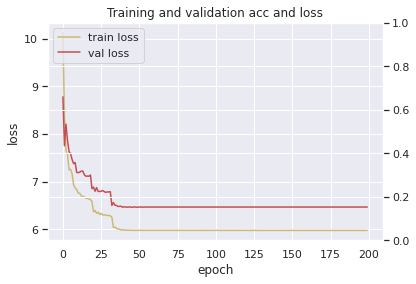

processing fold #: 3


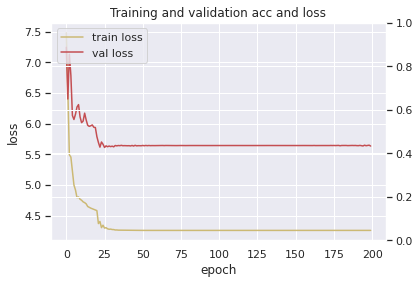

exprected_value 2.8779145002365114 real_value [3.23214286]
exprected_value 2.8154920959472656 real_value [3.1547619]
exprected_value 2.4554115629196165 real_value [5.23809524]
exprected_value 2.783286108970642 real_value [4.14285714]
exprected_value 3.2009854888916016 real_value [4.32142857]
exprected_value 2.8405910396575926 real_value [3.86309524]


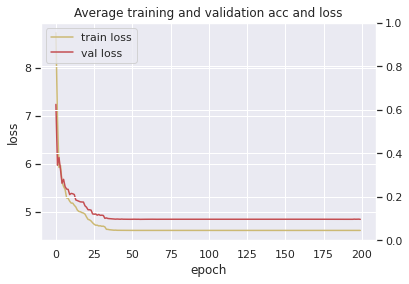

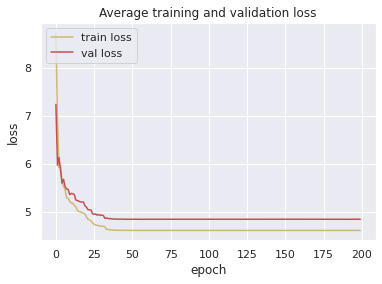

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 124, 64)           448       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 62, 64)            0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 3968)              0         
_________________________________________________________________
dense_69 (Dense)             (None, 50)                198450    
Total params: 198,898
Trainable params: 198,898
Non-trainable params: 0
_________________________________________________________________
exprected_value 3.079341254234314 	 real_value [3.23214286]
exprected_value 2.7488042163848876 	 real_value [3.1547619]
exprected_value 2.558781509399414 	 real_value [5.23809524]
exprected_value 2.7617402145266534 	 real_value [4.14285714]
expr

In [39]:
################################################################################
# : Neural network (1D convolutional neural network), Continuous
################################################################################
"""
Pending, CNN 1D with inputshape (125,3)
"""

train_data = tr_data3.copy()
test_data = te_data3.copy()
train_label = tr_label.copy()
test_label = te_label.copy()

def build_model():
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu',
                           input_shape=(125,3)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.compile(optimizer='adam',loss='mse')
    return model

# K-fold cross-validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 200
all_acc_histories = []
all_loss_histories = []
all_val_loss_histories = []
all_val_acc_histories = []

for i in range(k):
    print('processing fold #:', i)
    val_data = train_data[i*num_val_samples: (i + 1)*num_val_samples]
    val_label = train_label[i*num_val_samples: (i+1)*num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis = 0)
    partial_train_label = np.concatenate(
        [train_label[:i * num_val_samples],
         train_label[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_label,
                        validation_data=(val_data, val_label),
                        epochs = num_epochs, batch_size=5, verbose=0)

    # Shows the acc and loss plot
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    plt.title('Training and validation acc and loss')
    loss_ax.plot(history.history['loss'],'y',label = 'train loss')
    loss_ax.plot(history.history['val_loss'],'r',label = 'val loss')

    #acc_ax.plot(history.history['acc'],'b',label = 'train acc')
    #acc_ax.plot(history.history['val_acc'],'g',label = 'val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    #acc_ax.set_ylabel('accuracy')

    loss_ax.legend(loc = 'upper left')
    #acc_ax.legend(loc = 'lower left')
    plt.show()

    # Save the histories: acc, loss, val_acc, and val_loss
    #all_acc_histories.append(history.history['acc'])
    all_loss_histories.append(history.history['loss'])
    #all_val_acc_histories.append(history.history['val_acc'])
    all_val_loss_histories.append(history.history['val_loss'])

result = model.predict(test_data, verbose=0)
for i, e in enumerate(result):
    print("exprected_value",sum(e,0.0)/len(e), "real_value", test_label[i])
#print( result)
#print(test_label)

# Compute the average histories
#average_acc_history = [
#            np.mean([x[i] for x in all_acc_histories])
#            for i in range(num_epochs)]
average_loss_history = [
            np.mean([x[i] for x in all_loss_histories]) 
            for i in range(num_epochs)]
#average_val_acc_history = [
#            np.mean([x[i] for x in all_val_acc_histories]) 
#            for i in range(num_epochs)]
average_val_loss_history = [
            np.mean([x[i] for x in all_val_loss_histories]) 
            for i in range(num_epochs)]

# Shows the average acc and loss plot
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
plt.title('Average training and validation acc and loss')
loss_ax.plot(average_loss_history,'y',label = 'train loss')
loss_ax.plot(average_val_loss_history,'r',label = 'val loss')
#acc_ax.plot(average_acc_history,'b',label = 'train acc')
#acc_ax.plot(average_val_acc_history,'g',label = 'val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc = 'upper left')
#acc_ax.legend(loc = 'lower left')
plt.show()

# Shows the average loss plot
fig, loss_ax = plt.subplots()
plt.title('Average training and validation loss')
loss_ax.plot(average_loss_history,'y',label = 'train loss')
loss_ax.plot(average_val_loss_history,'r',label = 'val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc = 'upper left')
plt.show()

model.summary()

# final training and prediction
model.fit(train_data, train_label, epochs =100, verbose=0)
result = model.predict(test_data)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", test_label[i])
print(model.evaluate(test_data, test_label))
# print(result)
# print(test_label)
print(model.evaluate(test_data, test_label))

In [42]:
################################################################################
# : Neural network (Shallow neural network), Continuous
################################################################################
"""
Pending, Shallow network with inputshape (251,1)
No-specific validation, no cross-validation
"""
train_data = tr_data3.copy()
test_data = te_data3.copy()
train_label = tr_label.copy()
test_label = te_label.copy()

model = Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape =(125,3)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(50,activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

# final training and prediction
model.fit(train_data, train_label, epochs =100, verbose=0)
result = model.predict(test_data)
for i, e in enumerate(result):
    print("expected_value",sum(e,0.0)/len(e), '\t', "real_value", test_label[i])
print(model.evaluate(test_data, test_label))
# print(result)
# print(test_label)
print(model.evaluate(test_data, test_label))

exprected_value 3.8943190574645996 	 real_value [3.23214286]
exprected_value 3.9655609130859375 	 real_value [3.1547619]
exprected_value 3.7711007595062256 	 real_value [5.23809524]
exprected_value 3.630964756011963 	 real_value [4.14285714]
exprected_value 4.808976173400879 	 real_value [4.32142857]
exprected_value 4.219755172729492 	 real_value [3.86309524]
1/1 [==============================] - 0s 1ms/step - loss: 0.6458
0.6458145976066589
1/1 [==============================] - 0s 1ms/step - loss: 0.6458
0.6458145976066589


In [ ]:
################################################################################
# : CNN-RNN Multi Input Model, functional API
################################################################################

# valence
# arousal
# openess

input_valence = Input(shape=(None,), dtype='list')
embedded_valence = layers.Embedding(
    valence, 64)(input_valence)

# CNN-RNN
# econded_valence
    
input_arousal = Input(shape=(None,), dtype='list')
embedded_arousal = layers.Embedding(
    arousal, 64)(input_arousal)

# CNN-RNN
# encoded_arousal

input_openness = Input(shape=(None,), dtype='float')
embedded_openness = layers.Embedding(
    openess, 1((input_openess))

# Dense
# encoded_openness

concatenated = layers.concatenate([e_valence, e_arousal, e_openness], axis = -1)
answer = layers.


# k-fold, and data transformation work needed